In [1]:
import sunpy
import sunpy.map
from sunpy.net import vso

import datetime
from datetime import datetime
from datetime import timedelta

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.io import fits
from astropy.vo.samp import SAMPIntegratedClient

In [55]:
class VSOHandler(object):
    def __init__(self, timestamp, instrument, wave):
        self.timestamp = timestamp
        self.askedTime = datetime.strptime(self.timestamp,'%Y/%m/%dT%H:%M:%S.%f')
        self.instrument = instrument
        #ToDo: support other instruments
        self.instrument = 'AIA'
        self.wave = wave
        
        self.client = vso.VSOClient()
        
    def createQuery(self, deltaFrom=timedelta(minutes = 2), deltaTo=timedelta(seconds=0)):        
        self.query = self.client.query(
            vso.attrs.Time(self.askedTime - deltaFrom , self.askedTime + deltaTo),
            vso.attrs.Instrument(self.instrument),
            vso.attrs.Wave(self.wave * u.AA, self.wave * u.AA))
        return self.query
    
    def createQuerySingleResult(self):          
        deltaFromCur = timedelta(minutes = 2)
        deltaFromMin = timedelta(seconds = 0)
        
        # images are usually stored all 3 minutes
        # unless something interesting happens, then it is every 3 seconds
        self.createQuery(deltaFrom = deltaFromCur)
        
        if(len(self.query) > 1):
            self.createQuery(deltaFrom = timedelta(seconds=5))
            if(len(self.query) > 1):
                deltaFromCur = timedelta(seconds=5)
        
        while(len(self.query) != 1):
            
            if(len(self.query) < 1):
                deltaFromMin = deltaFromCur
                deltaFromCur = deltaFromCur * 2
            else:
                deltaFromCur = (deltaFromMin + deltaFromCur)/2
            self.createQuery(deltaFrom = deltaFromCur)
        return self.query
    
    def checkResult(self):
        print(self.query)
    
    def showData(self):
        self.files = self.client.get(self.query, path='/Data/{instrument}/{file}.fits').wait()
        self.smap = list()
                    
        for file in self.files:
            curMap = sunpy.map.Map(file)
            self.smap.append(curMap)
            plt.figure(figsize=(15,15))

            curMap.plot()
            curMap.draw_limb()

            plt.colorbar()
            plt.show()
        
        
        #self.hdu_list = fits.open(files[0])
        #self.hdu_list.info()
        #self.image_data = hdu_list[0].data
        #self.hdu_list.close()
        #del(self.hdu_list)
        
        #fig = plt.figure(figsize=(20,20))
        #fig.imshow(self.image_data)
        #fig.colorbar()
        

class Receiver(object):
    def __init__(self, client):
        self.client = client
        self.received = False
    def receive_call(self, private_key, sender_id, msg_id, mtype, params, extra):
        self.params = params
        self.received = True
        self.client.reply(msg_id, {"samp.status": "samp.ok", "samp.result": {}})
    def receive_notification(self, private_key, sender_id, mtype, params, extra):
        self.params = params
        self.received = True
    
    def createHandler(self):
        if self.received:
            timestamp = self.params['timestamp']
            wave = int(self.params['wave'])
            instrument = self.params['instrument']
            self.received = False 
            
            handler = VSOHandler(timestamp, instrument, wave)
            handler.createQuerySingleResult()
            
            return handler

In [56]:
client = SAMPIntegratedClient()
client.connect()

r = Receiver(client)
client.bind_receive_call("jhv.vso.load", r.receive_call)
client.bind_receive_notification("jhv.vso.load", r.receive_notification)

In [57]:
r.received

False

In [58]:
# We test every 0.1s to see if the hub has sent a message
import time
while True:
    time.sleep(0.1)
    if r.received:
        handler = r.createHandler()
        break

In [38]:
#handler.createQuery(timedelta(seconds=10), timedelta(seconds=5))

Start Time [1],End Time [1],Source,Instrument,Type
str19,str19,str3,str3,str8
2017-04-02 14:30:05,2017-04-02 14:30:06,SDO,AIA,FULLDISK


In [60]:
handler.query

Start Time [1],End Time [1],Source,Instrument,Type
str19,str19,str3,str3,str8
2017-04-02 20:29:53,2017-04-02 20:29:54,SDO,AIA,FULLDISK


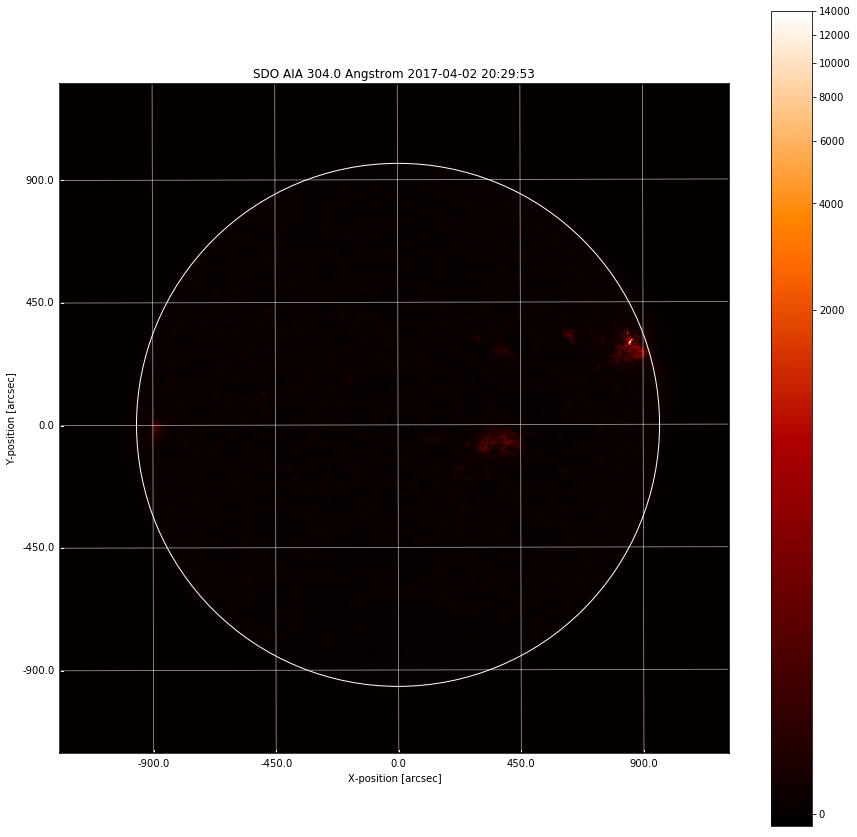

In [59]:
handler.showData()

In [33]:
handler.files

[]